Библиотеки

In [ ]:
# Импорт PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F

# Импорт NumPy
import numpy as np

# Импорт Matplotlib
import matplotlib.pyplot as plt

# Импорт Librosa
import librosa
import librosa.display

#импорт os
import os

пути для входных и целевых данных

In [2]:
mix_dir = "C:\для учебы\Диплом\Диплом маг\DataSet\SDataSet\mix"
inst_dir = "C:\для учебы\Диплом\Диплом маг\DataSet\SDataSet\instruments"

Класс дата-сета

In [3]:
class MusicSeparationDataset(Dataset):
    def __init__(self, mix_dir, instruments_dir):
        self.mix_dir = mix_dir
        self.instruments_dir = instruments_dir

        self.tracks = sorted([ f for f in os.listdir(mix_dir) if f.endswith('.flac')])

        self.instrument_classes = ['Bass','Drums','Guitars','Keys']
        
    def __len__(self):
        return len(self.tracks)
    
    def __getitem__(self, idx, sr=44100):
        self.sr = sr
        self.track_id = self.tracks[idx]
        track_name = os.path.splitext(self.track_id)[0]

        mix_path = os.path.join(self.mix_dir, track_name)
        mix_waveform, sr = torchaudio.load(mix_path+".flac")

         # Преобразование: Waveform -> Spectrogram
        spectrogram_transform = T.Spectrogram(n_fft=1024, hop_length=512, power=2)
        mix_spec = spectrogram_transform(mix_waveform)

        targets = []
        for inst in self.instrument_classes:
            inst_path = os.path.join(self.instruments_dir, inst, track_name)
            inst_waveform, _ = torchaudio.load(inst_path+".flac")
            # Спектрограмма каждого инструмента
            inst_spec = spectrogram_transform(inst_waveform)
            targets.append(inst_spec)
        
        target_tensor = torch.stack(targets)
        return mix_spec, target_tensor

In [4]:
class MusicSeparationDataset(Dataset):
    def __init__(self, mix_dir, instruments_dir, n_fft=1024, hop_length=512):
        self.mix_dir = mix_dir
        self.instruments_dir = instruments_dir
        self.tracks = sorted([f for f in os.listdir(mix_dir) if f.endswith('.flac')])
        self.instrument_classes = ['Bass', 'Drums', 'Guitars', 'Keys']

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = n_fft
        self.window = torch.hann_window(self.n_fft)

    def __len__(self):
        return len(self.tracks)
    
    def __getitem__(self, idx):
        track_id = self.tracks[idx]
        track_name = os.path.splitext(track_id)[0]

        # Загрузка микса
        mix_path = os.path.join(self.mix_dir, track_name + ".flac")
        mix_waveform, sr = torchaudio.load(mix_path)

        # STFT для микса
        mix_spec = torch.stft(
            mix_waveform, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            return_complex=True
        )

        targets = []
        for inst in self.instrument_classes:
            inst_path = os.path.join(self.instruments_dir, inst, track_name + ".flac")
            inst_waveform, _ = torchaudio.load(inst_path)
            
            inst_spec = torch.stft(
                inst_waveform, 
                n_fft=self.n_fft, 
                hop_length=self.hop_length,
                win_length=self.win_length,
                window=self.window,
                return_complex=True
            )
            targets.append(inst_spec)

        target_tensor = torch.stack(targets)  # shape: [num_instruments, 1, freq, time]
        return mix_spec, target_tensor


In [5]:
data_set = MusicSeparationDataset(mix_dir, inst_dir)

In [6]:
len(data_set)

100

Data-loader

In [7]:
def collate_fn(batch):
    """
    Принимает список из N элементов, где каждый элемент — это (mix_waveform, target_tensor)
    mix_waveform: [1, T]
    target_tensor: [num_instruments, 1, T]
    """
    mixes, targets = zip(*batch)  # список миксов и список таргетов

    # Определим максимальную длину аудио в батче
    max_len = max(mix.shape[2] for mix in mixes)

    # Паддим миксы до max_len
    padded_mixes = [F.pad(mix, (0, max_len - mix.shape[2])) for mix in mixes]

    # Паддим каждый target (каждый target — это [N, 1, T])
    padded_targets = [F.pad(tgt, (0, max_len - tgt.shape[3])) for tgt in targets]

    # Собираем в тензоры батча
    mix_batch = torch.stack(padded_mixes)       # [B, 1, max_len]
    target_batch = torch.stack(padded_targets)  # [B, N, 1, max_len]

    return mix_batch, target_batch

In [8]:
dataloader = DataLoader(data_set, batch_size=4, collate_fn=collate_fn, shuffle=False)

In [11]:
for mix, targets in dataloader:
    print("Mix shape:", mix.shape)        # [4, 1, T]
    print("Targets shape:", targets.shape)  # [4, N, 1, T]
    print(mix[0][0][0])
    break  # только один batch


Mix shape: torch.Size([4, 1, 513, 23204])
Targets shape: torch.Size([4, 4, 1, 513, 23204])
tensor([0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j])


Модель

In [12]:
#Эмбеддинг-класс
class PatchEmbed(nn.Module):
    def __init__(self, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Linear(patch_size[0] * patch_size[1], embed_dim)

    def forward(self, x):  # x: [B, 1, T, F]
        B, C, T, F = x.shape
        t_p, f_p = self.patch_size
        x = x.unfold(2, t_p, t_p).unfold(3, f_p, f_p)  # [B, C, n_t, n_f, t_p, f_p]
        x = x.contiguous().view(B, -1, t_p * f_p)      # [B, Num_patches, Patch_dim]
        return self.proj(x)                            # [B, Num_patches, Embed_dim]


In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.ff(self.norm2(x))
        return x


In [14]:
class PatchDecoder(nn.Module):
    def __init__(self, patch_size, embed_dim, out_channels, out_shape):
        super().__init__()
        self.patch_size = patch_size
        self.out_shape = out_shape
        self.out_channels = out_channels
        self.proj = nn.Linear(embed_dim, patch_size[0] * patch_size[1] * out_channels)

    def forward(self, x):  # [B, Num_patches, Embed_dim]
        B, N, D = x.shape
        x = self.proj(x)  # [B, N, P×P×C]
        t_p, f_p = self.patch_size
        T, F = self.out_shape
        x = x.view(B, N, self.out_channels, t_p, f_p)
        # Расклеим обратно в 2D спектрограмму
        n_t = T // t_p
        n_f = F // f_p
        x = x.view(B, n_t, n_f, self.out_channels, t_p, f_p)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, self.out_channels, T, F)
        return x


In [15]:
class SimpleTransformerSeparator(nn.Module):
    def __init__(self, patch_size=(16, 16), embed_dim=256, num_heads=4, num_layers=4, num_targets=4):
        super().__init__()
        self.patch_embed = PatchEmbed(patch_size, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(embed_dim, patch_size[0] * patch_size[1] * num_targets)
        self.patch_size = patch_size
        self.num_targets = num_targets

    def forward(self, x):  # x: [B, 1, F, T]
        B, C, F, T = x.shape

        # 👉 Эмбеддинг: [B, num_patches, embed_dim]
        x = self.patch_embed(x)

        # 👉 Трансформер
        x = self.transformer(x)

        # 👉 Распаковываем
        x = self.output_proj(x)  # [B, num_patches, patch_size*patch_size*num_targets]

        # 👉 Преобразуем обратно в тензор [B, num_targets, F, T]
        num_patches = x.shape[1]
        t_p, f_p = self.patch_size
        T_p = T // t_p
        F_p = F // f_p

        x = x.view(B, num_patches, self.num_targets, t_p, f_p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(B, self.num_targets, T_p * t_p, F_p * f_p)
        return x


In [16]:

# Установка устройства — CPU
device = torch.device("cpu")

model = SimpleTransformerSeparator(
    patch_size=(256, 256),
    embed_dim=256,
    num_heads=4,
    num_layers=2,
    num_targets=4  # например: бас, ударные, гитары, клавиши
)

In [17]:
# тестовый прогон из даталоадера
for mix_spec, target_spec in dataloader:
    mix_spec = mix_spec.to(device)           # [B, 1, F, T]
    target_spec = target_spec.to(device)     # [B, 4, F, T]

    # паддинг до кратности 16
    pad_T = (16 - mix_spec.shape[-1] % 16) % 16
    pad_F = (16 - mix_spec.shape[-2] % 16) % 16

    if pad_T > 0 or pad_F > 0:
        mix_spec = F.pad(mix_spec, (0, pad_T, 0, pad_F))
        target_spec = F.pad(target_spec, (0, pad_T, 0, pad_F))

    with torch.no_grad():
        out = model(mix_spec)  # [B, 4, F, T]

    print("🎧 Input:", mix_spec.shape)
    print("📤 Output:", out.shape)
    print("🎯 Target:", target_spec.shape)
    break  # только один батч

RuntimeError: mat1 and mat2 must have the same dtype, but got ComplexFloat and Float

In [ ]:
out[0].shape
all_insts = out[0]
print(all_insts.shape)

torch.Size([4, 23040, 512])


In [50]:
inst = all_insts[2]
inst = (inst.T).unsqueeze(0) 

print(inst.shape)

torch.Size([1, 512, 23040])


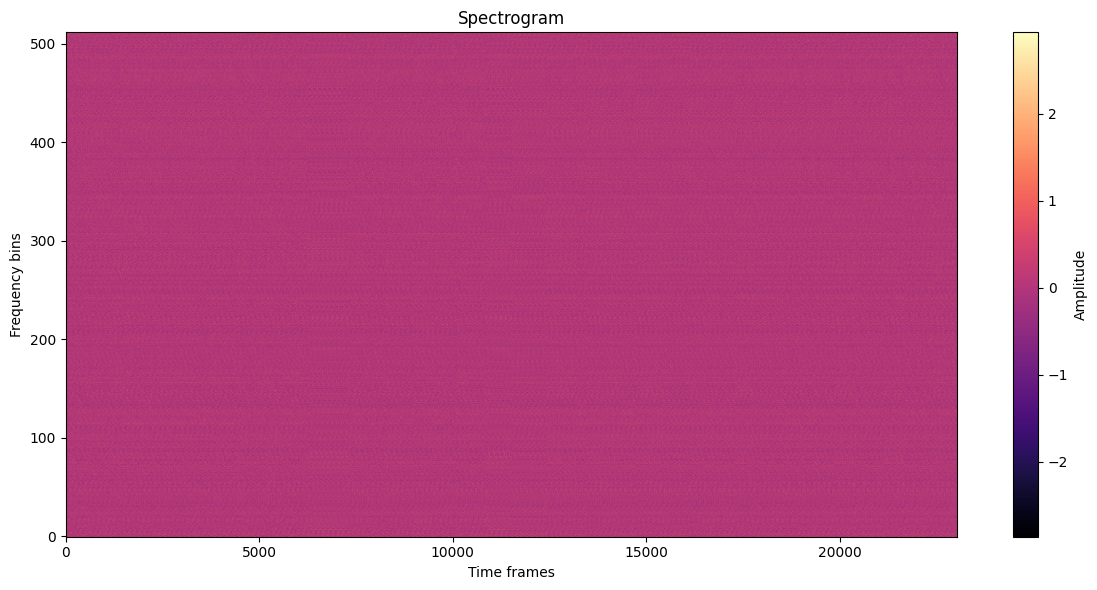

In [51]:
import torch
import matplotlib.pyplot as plt

spec = inst

# Удаляем размер батча
spec = spec.squeeze(0)  # теперь spec имеет размер [512, 23040]

# Визуализация
plt.figure(figsize=(12, 6))
plt.imshow(spec.numpy(), aspect='auto', origin='lower', cmap='magma')
plt.xlabel('Time frames')
plt.ylabel('Frequency bins')
plt.title('Spectrogram')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


In [56]:
import torch
import torchaudio.transforms as T
import torchaudio

# Предположим, у тебя тензор мощности спектра [1, 512, 23040]
spec = inst  # → [512, 23040]

# Преобразуем в амплитуду
spec_amplitude = torch.sqrt(spec + 1e-9)

# Параметры
n_fft = 1024
hop_length = 512

# Создаём объект GriffinLim (ТОЧНО transforms, НЕ functional!)
griffinlim = T.GriffinLim(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=n_fft,
    power=1.0,
    n_iter=32
)

# Применяем
waveform = griffinlim(spec_amplitude)  # [samples]


RuntimeError: istft(CPUComplexFloatType[1, 512, 23040], n_fft=1024, hop_length=512, win_length=1024, window=torch.FloatTensor{[1024]}, center=1, normalized=0, onesided=None, length=None, return_complex=0) : expected the frequency dimension (3rd to the last) of the input tensor to match n_fft / 2 + 1 when onesided=True, but got 512